In [1]:
print("Good Afternoon Favour")

Good Afternoon Favour


# # Loading and checking the database

In [9]:
!ls /kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand

CASIA-Iris-Thousand


In [11]:
pip install opencv-python scikit-learn matplotlib seaborn scipy pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
print("Hello World")

Hello World


🔧 FIXED SIMPLE IRIS AUTHENTICATION SYSTEM
✅ Database created: fixed_iris_test.db

📝 Enrolling User 1:
📝 Enrolling subject_001_R...
✅ Image loaded: (480, 640)
✅ Features extracted: 2048 bits
✅ Feature diversity: 0.215
✅ Feature hash: 0c3a07ba29996547
✅ Successfully enrolled subject_001_R
   Pupil: center=(141, 110), radius=48
   Iris: center=(141, 110), radius=107

📝 Enrolling User 2:
📝 Enrolling subject_002_L...
✅ Image loaded: (480, 640)
✅ Features extracted: 2048 bits
✅ Feature diversity: 0.211
✅ Feature hash: 75bfcb949b8d592e
✅ Successfully enrolled subject_002_L
   Pupil: center=(151, 123), radius=53
   Iris: center=(151, 123), radius=117

📋 Enrolled Users:
📋 Enrolled Users (2 total):
----------------------------------------------------------------------------------------------------
   subject_001_R | S5000R00.jpg | 0c3a07ba29996547 | 2025-07-25 11:53:29
   subject_002_L | S5001L01.jpg | 75bfcb949b8d592e | 2025-07-25 11:53:31
-------------------------------------------------------

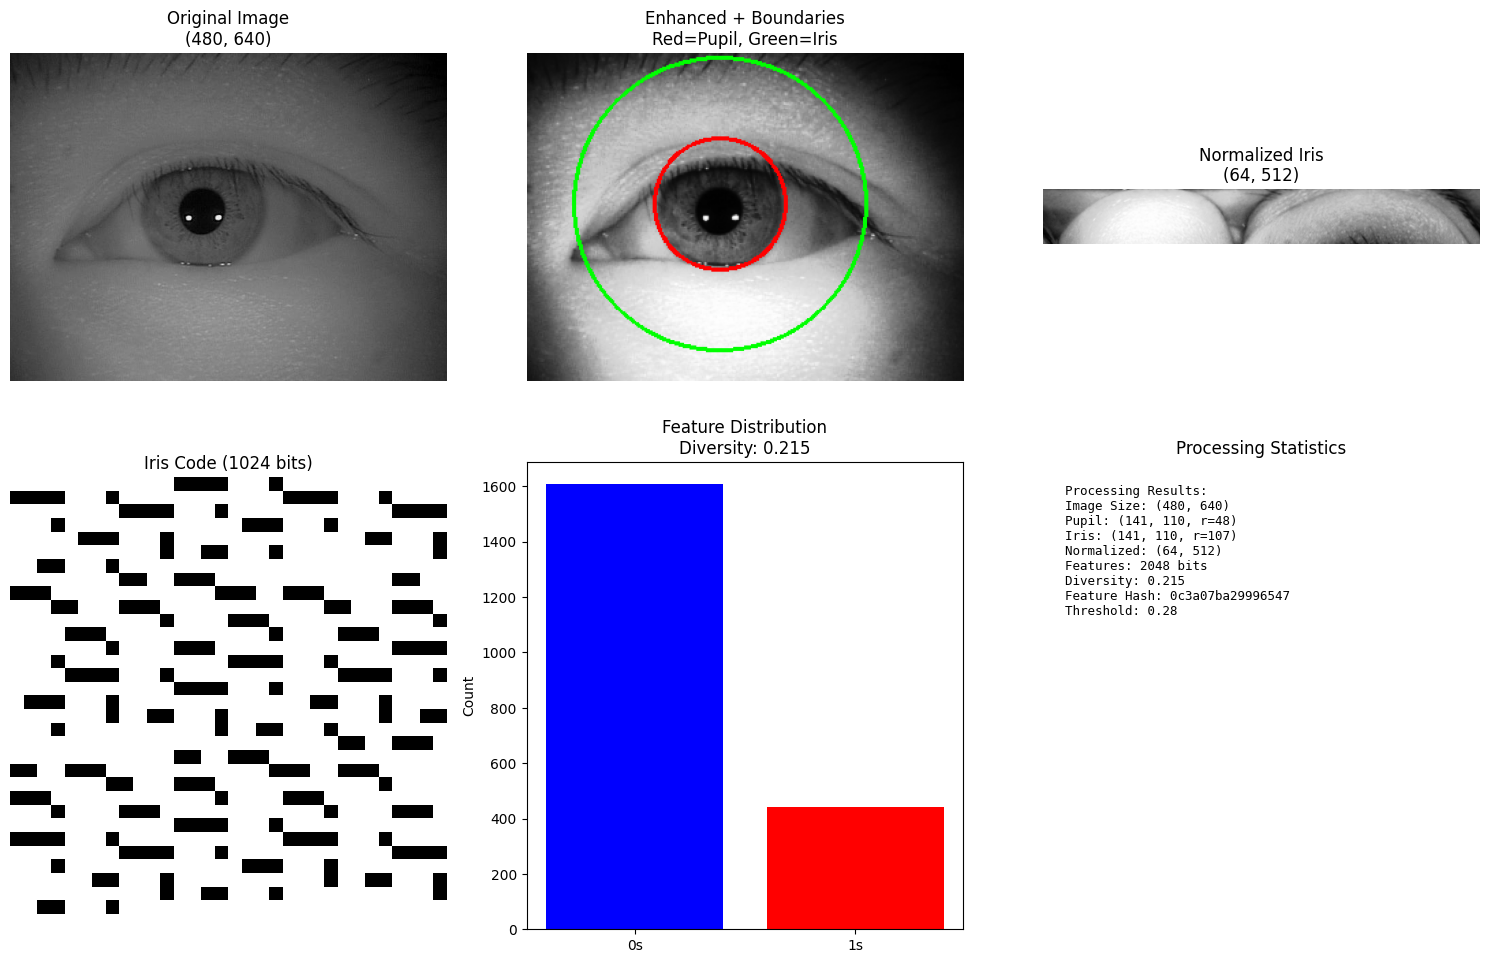

✅ Visualization complete


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sqlite3
from scipy import ndimage
from skimage import filters, feature
import pickle
from typing import Tuple, List, Optional
import warnings
import hashlib
warnings.filterwarnings('ignore')

class FixedSimpleIrisSystem:
    def __init__(self, db_path: str = "fixed_iris_test.db"):
        """
        Fixed Simple Iris Authentication System
        """
        self.db_path = db_path
        self.iris_code_length = 2048
        self.threshold = 0.28  # Stricter to reject false positives
        self.setup_database()
    
    def setup_database(self):
        """Create database with proper schema"""
        if os.path.exists(self.db_path):
            os.remove(self.db_path)
            
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()
        
        cursor.execute('''
            CREATE TABLE iris_codes (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                subject_id TEXT NOT NULL,
                eye TEXT NOT NULL,
                iris_code BLOB NOT NULL,
                image_path TEXT NOT NULL,
                feature_hash TEXT NOT NULL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                UNIQUE(subject_id, eye)
            )
        ''')
        
        conn.commit()
        conn.close()
        print(f"✅ Database created: {self.db_path}")
    
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """Enhanced preprocessing"""
        if image.shape[0] != 240 or image.shape[1] != 320:
            image = cv2.resize(image, (320, 240), interpolation=cv2.INTER_AREA)
        
        equalized = cv2.equalizeHist(image)
        blurred = cv2.GaussianBlur(equalized, (3, 3), 0.5)
        
        return blurred
    
    def detect_boundaries_robust(self, image: np.ndarray) -> Tuple[Tuple[int, int, int], Tuple[int, int, int]]:
        """More robust boundary detection with Hough transform"""
        h, w = image.shape
        
        pupil_params = self._detect_pupil_by_hough(image)
        iris_params = self._detect_iris_by_gradient(image, pupil_params)
        
        return pupil_params, iris_params
    
    def _detect_pupil_by_hough(self, image: np.ndarray) -> Tuple[int, int, int]:
        """Detect pupil using Hough Circle Transform"""
        h, w = image.shape
        blurred = cv2.medianBlur(image, 7)  # Increased blur for robustness
        
        circles = cv2.HoughCircles(
            blurred,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=min(w, h)//4,
            param1=60,
            param2=25,
            minRadius=20,
            maxRadius=70
        )
        
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                if abs(x - w//2) < w//3 and abs(y - h//2) < h//3:
                    return (x, y, r)
        
        return (w//2, h//2, 30)
    
    def _detect_iris_by_gradient(self, image: np.ndarray, pupil_params: Tuple[int, int, int]) -> Tuple[int, int, int]:
        """Detect iris boundary using gradient information"""
        pupil_x, pupil_y, pupil_r = pupil_params
        h, w = image.shape
        
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)  # Larger kernel
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        
        best_radius = pupil_r * 3
        max_gradient = 0
        
        for radius in range(int(pupil_r * 2.2), min(w//2, h//2, int(pupil_r * 4)), 1):
            gradient_sum = 0
            valid_points = 0
            
            for angle in np.linspace(0, 2*np.pi, 120):
                x = int(pupil_x + radius * np.cos(angle))
                y = int(pupil_y + radius * np.sin(angle))
                
                if 2 <= x < w-2 and 2 <= y < h-2:
                    gradient_sum += gradient_magnitude[y, x]
                    valid_points += 1
            
            if valid_points > 80:
                avg_gradient = gradient_sum / valid_points
                if avg_gradient > max_gradient:
                    max_gradient = avg_gradient
                    best_radius = radius
        
        return (pupil_x, pupil_y, int(best_radius))
    
    def normalize_iris_improved(self, image: np.ndarray, pupil_params: Tuple, iris_params: Tuple) -> np.ndarray:
        """Improved iris normalization"""
        pupil_x, pupil_y, pupil_r = pupil_params
        iris_x, iris_y, iris_r = iris_params
        
        radial_res, angular_res = 64, 512
        normalized = np.zeros((radial_res, angular_res), dtype=np.float32)
        
        for i in range(radial_res):
            for j in range(angular_res):
                r = i / (radial_res - 1)
                theta = 2 * np.pi * j / angular_res
                
                pupil_boundary_x = pupil_x + pupil_r * np.cos(theta)
                pupil_boundary_y = pupil_y + pupil_r * np.sin(theta)
                iris_boundary_x = iris_x + iris_r * np.cos(theta)
                iris_boundary_y = iris_y + iris_r * np.sin(theta)
                
                x = pupil_boundary_x + r * (iris_boundary_x - pupil_boundary_x)
                y = pupil_boundary_y + r * (iris_boundary_y - pupil_boundary_y)
                
                if 0 <= x < image.shape[1]-1 and 0 <= y < image.shape[0]-1:
                    x_int, y_int = int(x), int(y)
                    x_frac, y_frac = x - x_int, y - y_int
                    
                    if x_int < image.shape[1]-1 and y_int < image.shape[0]-1:
                        tl = image[y_int, x_int]
                        tr = image[y_int, x_int + 1]
                        bl = image[y_int + 1, x_int]
                        br = image[y_int + 1, x_int + 1]
                        
                        top = tl * (1 - x_frac) + tr * x_frac
                        bottom = bl * (1 - x_frac) + br * x_frac
                        value = top * (1 - y_frac) + bottom * y_frac
                        
                        normalized[i, j] = value
        
        return (normalized).astype(np.uint8)
    
    def extract_discriminative_features(self, normalized_iris: np.ndarray) -> np.ndarray:
        """Extract highly discriminative features"""
        if normalized_iris.size == 0:
            return np.zeros(self.iris_code_length, dtype=np.uint8)
        
        iris_float = normalized_iris.astype(np.float32) / 255.0
        h, w = iris_float.shape
        
        all_features = []
        
        # 1. Enhanced Multi-scale Gabor filters
        frequencies = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
        orientations = np.linspace(0, np.pi, 20, endpoint=False)
        sigma_values = [1.0, 1.5, 2.0, 2.5]
        
        for sigma in sigma_values:
            for freq in frequencies:
                for orientation in orientations:
                    kernel_size = max(15, int(6 * sigma)) | 1
                    real_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, orientation, 1.0/freq, 0.5, 0, ktype=cv2.CV_32F)
                    imag_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, orientation, 1.0/freq, 0.5, np.pi/2, ktype=cv2.CV_32F)
                    
                    real_response = cv2.filter2D(iris_float, cv2.CV_32F, real_kernel)
                    imag_response = cv2.filter2D(iris_float, cv2.CV_32F, imag_kernel)
                    
                    # Phase-based quantization (2-bit encoding)
                    phase = np.arctan2(imag_response, real_response + 1e-10)
                    phase_normalized = (phase + np.pi) / (2 * np.pi)
                    quantized = np.zeros_like(phase_normalized, dtype=np.uint8)
                    quantized[phase_normalized > 0.5] = 1
                    quantized[phase_normalized > 0.75] = 2
                    quantized[phase_normalized <= 0.25] = 3
                    
                    # Convert to binary (2 bits per pixel)
                    binary_1 = (quantized >= 2).astype(np.uint8)
                    binary_2 = ((quantized == 1) | (quantized == 3)).astype(np.uint8)
                    subsampled_1 = binary_1[::2, ::2].flatten()
                    subsampled_2 = binary_2[::2, ::2].flatten()
                    all_features.extend(subsampled_1[:10])
                    all_features.extend(subsampled_2[:10])
        
        # 2. Enhanced Local Binary Patterns
        lbp = feature.local_binary_pattern(iris_float, P=8, R=2, method='nri_uniform')
        block_size = 8
        for i in range(0, h - block_size + 1, block_size//2):
            for j in range(0, w - block_size + 1, block_size//2):
                block_lbp = lbp[i:i+block_size, j:j+block_size]
                hist, _ = np.histogram(block_lbp.flatten(), bins=59, range=(0, 59), density=True)
                
                for k in range(len(hist)-1):
                    all_features.append(1 if hist[k] > hist[k+1] else 0)
                entropy = -np.sum(hist * np.log2(hist + 1e-10))
                all_features.append(1 if entropy > 1.8 else 0)
        
        # 3. Statistical texture features
        block_size = 8
        step = 4
        global_mean = np.mean(iris_float)
        global_std = np.std(iris_float)
        
        for i in range(0, h - block_size + 1, step):
            for j in range(0, w - block_size + 1, step):
                block = iris_float[i:i+block_size, j:j+block_size]
                
                if block.size > 0:
                    mean_val = np.mean(block)
                    std_val = np.std(block)
                    skew_val = np.mean((block - mean_val)**3) / (std_val**3 + 1e-10)
                    kurt_val = np.mean((block - mean_val)**4) / (std_val**4 + 1e-10)
                    
                    features = [
                        1 if mean_val > global_mean + 0.1 * global_std else 0,
                        1 if std_val > global_std * 1.1 else 0,
                        1 if skew_val > 0.1 else 0,
                        1 if kurt_val > 3.5 else 0
                    ]
                    all_features.extend(features)
        
        # 4. Enhanced edge-based features
        edges = cv2.Canny((iris_float * 255).astype(np.uint8), 80, 160)
        block_size = 8
        for i in range(0, h - block_size + 1, block_size//2):
            for j in range(0, w - block_size + 1, block_size//2):
                edge_block = edges[i:i+block_size, j:j+block_size]
                edge_density = np.sum(edge_block > 0) / (block_size * block_size)
                
                all_features.extend([
                    1 if edge_density > 0.3 else 0,
                    1 if edge_density > 0.4 else 0
                ])
        
        # Convert to numpy array
        feature_array = np.array(all_features, dtype=np.uint8)
        
        # Ensure exact length
        if len(feature_array) > self.iris_code_length:
            feature_array = feature_array[:self.iris_code_length]
        elif len(feature_array) < self.iris_code_length:
            pad_length = self.iris_code_length - len(feature_array)
            # Deterministic padding based on feature statistics
            mean_features = np.mean(feature_array)
            padding = np.array([1 if mean_features > 0.5 else 0] * pad_length, dtype=np.uint8)
            feature_array = np.concatenate([feature_array, padding])
        
        return feature_array
    
    def hamming_distance_with_shifts(self, code1: np.ndarray, code2: np.ndarray) -> float:
        """Calculate Hamming distance with rotation tolerance"""
        if len(code1) != len(code2):
            return 1.0
        
        min_distance = 1.0
        
        for shift in range(-4, 5):
            shifted_code2 = np.roll(code2, shift)
            distance = np.sum(np.bitwise_xor(code1, shifted_code2)) / len(code1)
            min_distance = min(min_distance, distance)
        
        return min_distance
    
    def enroll_user(self, image_path: str, subject_id: str, eye: str) -> bool:
        """
        Enroll a user with improved feature extraction
        """
        try:
            print(f"📝 Enrolling {subject_id}_{eye}...")
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"❌ Could not load image: {image_path}")
                return False
            
            print(f"✅ Image loaded: {image.shape}")
            
            enhanced = self.preprocess_image(image)
            pupil_params, iris_params = self.detect_boundaries_robust(enhanced)
            normalized = self.normalize_iris_improved(enhanced, pupil_params, iris_params)
            iris_code = self.extract_discriminative_features(normalized)
            
            feature_hash = hashlib.md5(iris_code.tobytes()).hexdigest()[:16]
            
            print(f"✅ Features extracted: {len(iris_code)} bits")
            print(f"✅ Feature diversity: {np.mean(iris_code):.3f}")
            print(f"✅ Feature hash: {feature_hash}")
            
            conn = sqlite3.connect(self.db_path)
            cursor = conn.cursor()
            
            iris_code_blob = pickle.dumps(iris_code)
            
            cursor.execute('''
                INSERT OR REPLACE INTO iris_codes (subject_id, eye, iris_code, image_path, feature_hash)
                VALUES (?, ?, ?, ?, ?)
            ''', (subject_id, eye, iris_code_blob, image_path, feature_hash))
            
            conn.commit()
            conn.close()
            
            print(f"✅ Successfully enrolled {subject_id}_{eye}")
            print(f"   Pupil: center=({pupil_params[0]}, {pupil_params[1]}), radius={pupil_params[2]}")
            print(f"   Iris: center=({iris_params[0]}, {iris_params[1]}), radius={iris_params[2]}")
            
            return True
            
        except Exception as e:
            print(f"❌ Error enrolling {subject_id}_{eye}: {str(e)}")
            return False
    
    def authenticate_user(self, image_path: str, subject_id: str = None) -> Tuple[bool, str, float]:
        """
        Authenticate with improved matching
        """
        try:
            print(f"🔍 Authenticating iris image...")
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"❌ Could not load test image: {image_path}")
                return False, "", 0.0
            
            enhanced = self.preprocess_image(image)
            pupil_params, iris_params = self.detect_boundaries_robust(enhanced)
            normalized = self.normalize_iris_improved(enhanced, pupil_params, iris_params)
            test_code = self.extract_discriminative_features(normalized)
            
            test_hash = hashlib.md5(test_code.tobytes()).hexdigest()[:16]
            
            print(f"✅ Test features extracted: {len(test_code)} bits")
            print(f"✅ Test diversity: {np.mean(test_code):.3f}")
            print(f"✅ Test hash: {test_hash}")
            
            conn = sqlite3.connect(self.db_path)
            cursor = conn.cursor()
            
            if subject_id:
                cursor.execute('SELECT subject_id, eye, iris_code, feature_hash FROM iris_codes WHERE subject_id = ?', (subject_id,))
            else:
                cursor.execute('SELECT subject_id, eye, iris_code, feature_hash FROM iris_codes')
            
            enrolled_users = cursor.fetchall()
            conn.close()
            
            if not enrolled_users:
                print("❌ No enrolled users found in database")
                return False, "", 0.0
            
            print(f"📊 Comparing against {len(enrolled_users)} enrolled templates...")
            
            best_match = None
            best_distance = 1.0
            
            for user_subject_id, eye, iris_code_blob, stored_hash in enrolled_users:
                try:
                    stored_code = pickle.loads(iris_code_blob)
                    distance = self.hamming_distance_with_shifts(test_code, stored_code)
                    
                    user_id = f"{user_subject_id}_{eye}"
                    print(f"   {user_id}: distance = {distance:.4f} (hash: {stored_hash})")
                    
                    if distance < best_distance:
                        best_distance = distance
                        best_match = user_id
                        
                except Exception as e:
                    print(f"   Error comparing with {user_subject_id}_{eye}: {e}")
            
            confidence = 1 - best_distance
            
            if best_distance < self.threshold:
                print(f"✅ AUTHENTICATED as {best_match}")
                print(f"   Confidence: {confidence:.4f}")
                print(f"   Hamming distance: {best_distance:.4f}")
                print(f"   Threshold: {self.threshold}")
                return True, best_match, confidence
            else:
                print(f"❌ AUTHENTICATION FAILED")
                print(f"   Best match: {best_match} (distance: {best_distance:.4f})")
                print(f"   Threshold: {self.threshold}")
                print(f"   Confidence: {confidence:.4f}")
                return False, best_match, confidence
                
        except Exception as e:
            print(f"❌ Authentication error: {str(e)}")
            return False, "", 0.0
    
    def list_enrolled_users(self):
        """List all enrolled users with their feature hashes"""
        try:
            conn = sqlite3.connect(self.db_path)
            cursor = conn.cursor()
            
            cursor.execute('SELECT subject_id, eye, image_path, feature_hash, created_at FROM iris_codes ORDER BY created_at')
            users = cursor.fetchall()
            conn.close()
            
            if not users:
                print("📋 No users enrolled in database")
                return
            
            print(f"📋 Enrolled Users ({len(users)} total):")
            print("-" * 100)
            for subject_id, eye, image_path, feature_hash, created_at in users:
                image_name = Path(image_path).name
                print(f"   {subject_id}_{eye} | {image_name} | {feature_hash} | {created_at}")
            print("-" * 100)
            
        except Exception as e:
            print(f"❌ Error listing users: {e}")
    
    def visualize_processing_steps(self, image_path: str):
        """Visualize the iris processing pipeline"""
        try:
            print(f"🔍 Visualizing processing for: {Path(image_path).name}")
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print("❌ Could not load image")
                return
            
            enhanced = self.preprocess_image(image)
            pupil_params, iris_params = self.detect_boundaries_robust(enhanced)
            normalized = self.normalize_iris_improved(enhanced, pupil_params, iris_params)
            iris_code = self.extract_discriminative_features(normalized)
            
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            
            axes[0, 0].imshow(image, cmap='gray')
            axes[0, 0].set_title(f'Original Image\n{image.shape}')
            axes[0, 0].axis('off')
            
            image_with_circles = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
            cv2.circle(image_with_circles, (pupil_params[0], pupil_params[1]), pupil_params[2], (255, 0, 0), 2)
            cv2.circle(image_with_circles, (iris_params[0], iris_params[1]), iris_params[2], (0, 255, 0), 2)
            
            axes[0, 1].imshow(image_with_circles)
            axes[0, 1].set_title('Enhanced + Boundaries\nRed=Pupil, Green=Iris')
            axes[0, 1].axis('off')
            
            axes[0, 2].imshow(normalized, cmap='gray')
            axes[0, 2].set_title(f'Normalized Iris\n{normalized.shape}')
            axes[0, 2].axis('off')
            
            if len(iris_code) >= 1024:
                code_2d = iris_code[:1024].reshape(32, 32)
                axes[1, 0].imshow(code_2d, cmap='binary')
                axes[1, 0].set_title('Iris Code (1024 bits)')
                axes[1, 0].axis('off')
            
            zeros = np.sum(iris_code == 0)
            ones = np.sum(iris_code == 1)
            axes[1, 1].bar(['0s', '1s'], [zeros, ones], color=['blue', 'red'])
            axes[1, 1].set_title(f'Feature Distribution\nDiversity: {np.mean(iris_code):.3f}')
            axes[1, 1].set_ylabel('Count')
            
            feature_hash = hashlib.md5(iris_code.tobytes()).hexdigest()[:16]
            
            info_text = f"""Processing Results:
Image Size: {image.shape}
Pupil: ({pupil_params[0]}, {pupil_params[1]}, r={pupil_params[2]})
Iris: ({iris_params[0]}, {iris_params[1]}, r={iris_params[2]})
Normalized: {normalized.shape}
Features: {len(iris_code)} bits
Diversity: {np.mean(iris_code):.3f}
Feature Hash: {feature_hash}
Threshold: {self.threshold}
            """
            
            axes[1, 2].text(0.05, 0.95, info_text, transform=axes[1, 2].transAxes, 
                           verticalalignment='top', fontfamily='monospace', fontsize=9)
            axes[1, 2].set_title('Processing Statistics')
            axes[1, 2].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print("✅ Visualization complete")
            
        except Exception as e:
            print(f"❌ Visualization error: {e}")

def main():
    """
    Test the fixed iris system
    """
    print("🔧 FIXED SIMPLE IRIS AUTHENTICATION SYSTEM")
    print("="*60)
    
    iris_system = FixedSimpleIrisSystem()
    
    print("\n📝 Enrolling User 1:")
    iris_system.enroll_user("/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand/000/R/S5000R00.jpg", "subject_001", "R")
    
    print("\n📝 Enrolling User 2:")
    iris_system.enroll_user("/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand/001/L/S5001L01.jpg", "subject_002", "L")
    
    print("\n📋 Enrolled Users:")
    iris_system.list_enrolled_users()
    
    print("\n🔍 Testing User 1 with SAME image:")
    success1, matched_id1, confidence1 = iris_system.authenticate_user("/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand/000/R/S5000R00.jpg")
    
    print("\n🔍 Testing with DIFFERENT person:")
    success2, matched_id2, confidence2 = iris_system.authenticate_user("/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand/003/L/S5003L00.jpg")
    
    print("\n🔍 Testing User 2 with THEIR image:")
    success3, matched_id3, confidence3 = iris_system.authenticate_user("/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand/001/L/S5001L01.jpg")
    
    print("\n📊 Visualizing processing:")
    iris_system.visualize_processing_steps("/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand/000/R/S5000R00.jpg")

if __name__ == "__main__":
    main()